# Loading Input Files and Reporting Results

## Introduction

In the previous tutorial in this series, we listed three primary methods for setting up and running simulations with OpenMM.  We have already seen how to use OpenMM Setup to prepare a simulation from a Protein Data Bank structure and generate a Python script to run OpenMM.  Here, we will consider the second method, and show how to use OpenMM to load input files prepared outside of OpenMM.  We will also explore the various options offered by OpenMM for reporting simulation results.  This tutorial assumes that you are familiar with the material in the previous tutorial and already have OpenMM and OpenMM Setup installed.  If not, refer to [Getting Started with OpenMM](getting_started.ipynb) before returning here.

In this tutorial, we will use input files generated by the LEaP utility in AmberTools.  Using LEaP or other features of AmberTools is out of the scope of the tutorial, and completing it does not require prior knowledge of these tools.  However, you may consult the Amber [tutorials](https://ambermd.org/tutorials/) or [reference manuals](https://ambermd.org/tutorials/) if you are looking for more information.  As we will discuss, OpenMM provides nearly identical mechanisms for loading CHARMM and Gromacs files, so you can easily adapt the instructions given here to these cases.

## Preparing Input Files

Two kinds of Amber input files are needed to specify the initial state of a simulation: *prmtop* files specifying the atoms in a system and the interactions between them, and *inpcrd* files providing a set of initial coordinates.  Compared with a PDB or PDBx/mmCIF file specifying atoms and their connectivity, a prmtop file contains all of the interaction parameters for bonds, angles, *etc.* in a system.  As such, no separate force field files are needed when setting up a simulation from a prmtop.  Instead, you use a tool like LEaP to generate a prmtop from a description of a topology along with Amber force field data files.  For this tutorial, as an example, we have used LEaP to create prmtop and inpcrd files for alanine dipeptide in water by running the following LEaP input script:

```
source leaprc.protein.ff19SB
source leaprc.water.opc
chain = sequence { ACE ALA NME }
solvateoct chain OPCBOX 10
saveamberparm chain input.prmtop input.inpcrd
quit
```

This creates a single alanine dipeptide molecule, solvates it, and parameterizes it with the Amber ff19SB force field and the OPC water model.  The output files, `input.prmtop` and `input.inpcrd`, are already provided with this tutorial, so it is not necessary to run LEaP yourself if you want to follow along.  However, if you want to experiment with modifications to the input files, you could [install AmberTools](https://ambermd.org/GetAmber.php#ambertools) and regenerate the files yourself with a command like
```shell
tleap -f input.dat
```
after saving the above LEaP commands to a file `input.dat`, for instance.

We will again use OpenMM Setup to generate a starting input file.  Since the previous tutorial covers [installing and running OpenMM Setup](getting_started.ipynb#Installing-OpenMM-and-Running-OpenMM-Setup) in detail, we will not discuss it at length again.  To work with Amber files in OpenMM Setup, simply choose the "Amber" option from the start page instead of the "PDB" option.  Select your prmtop and inpcrd files when prompted.  Since LEaP has already done all of the work of assigning force field parameters, there are no further preparation steps required before OpenMM Setup generates an input script.  For this example, we can keep the default options, except that we will equilibrate for 10,000 steps and run for only 100,000 steps.  This will generate a script that looks like:

```python
# This script was generated by OpenMM-Setup on 2025-09-25.

from openmm import *
from openmm.app import *
from openmm.unit import *

# Input Files

inpcrd = AmberInpcrdFile('input.inpcrd')
prmtop = AmberPrmtopFile('input.prmtop', periodicBoxVectors=inpcrd.boxVectors)

# System Configuration

nonbondedMethod = PME
nonbondedCutoff = 1.0*nanometers
constraints = HBonds
rigidWater = True
constraintTolerance = 0.000001
hydrogenMass = 1.5*amu
ewaldErrorTolerance = 0.0005

# Integration Options

dt = 0.004*picoseconds
temperature = 300*kelvin
friction = 1.0/picosecond
pressure = 1.0*atmospheres
barostatInterval = 25

# Simulation Options

steps = 100000
equilibrationSteps = 10000
dcdReporter = DCDReporter('trajectory.dcd', 10000)
dataReporter = StateDataReporter('log.txt', 1000, totalSteps=steps,
    step=True, speed=True, progress=True, potentialEnergy=True, temperature=True, separator='\t')
checkpointReporter = CheckpointReporter('checkpoint.chk', 10000)

# Prepare the Simulation

print('Building system...')
topology = prmtop.topology
positions = inpcrd.positions
system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
    constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance, hydrogenMass=hydrogenMass)
system.addForce(MonteCarloBarostat(pressure, temperature, barostatInterval))
integrator = LangevinMiddleIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(topology, system, integrator)
simulation.context.setPositions(positions)

# Minimize and Equilibrate

print('Performing energy minimization...')
simulation.minimizeEnergy()
print('Equilibrating...')
simulation.context.setVelocitiesToTemperature(temperature)
simulation.step(equilibrationSteps)

# Simulate

print('Simulating...')
simulation.reporters.append(dcdReporter)
simulation.reporters.append(dataReporter)
simulation.reporters.append(checkpointReporter)
simulation.currentStep = 0
simulation.step(steps)
```

## The Simulation Script

Let us examine the script generated by OpenMM Setup for these inputs.  Some of the code should be familiar from the previous tutorial, and we will spend most of our time here explaining what is new, as well as making a few modifications.  First, as before, we import names from OpenMM's modules:

In [1]:
from openmm import *
from openmm.app import *
from openmm.unit import *

### Input Files

Now, instead of loading a PDBx/mmCIF file and an OpenMM force field, we first load the input coordinates in the inpcrd file, followed by the topology and parameter data in the prmtop file.  This is done with OpenMM's [AmberInpcrdFile](https://docs.openmm.org/latest/api-python/generated/openmm.app.amberinpcrdfile.AmberInpcrdFile.html) and [AmberPrmtopFile](https://docs.openmm.org/latest/api-python/generated/openmm.app.amberprmtopfile.AmberPrmtopFile.html) classes, respectively.

In [2]:
inpcrd = AmberInpcrdFile('input.inpcrd')
prmtop = AmberPrmtopFile('input.prmtop', periodicBoxVectors=inpcrd.boxVectors)

Note that we pass periodic box vectors loaded as the `boxVectors` attribute of the inpcrd file as a `periodicBoxVectors` argument to AmberPrmtopFile.  Even though we do not need the position coordinates from the inpcrd file until we have already created an OpenMM Context, and the box vectors will fluctuate throughout the simulation if we add a barostat, it is necessary for OpenMM to know an *initial* set of box vectors when a Context is created.  These initial vectors get passed through an OpenMM System object that we will create later from the AmberPrmtopFile, so we need to provide them when creating the AmberPrmtopFile.

### Simulation Parameters

Next, we define system parameters:

In [3]:
# System Configuration

nonbondedMethod = PME
nonbondedCutoff = 1.0*nanometers
constraints = HBonds
rigidWater = True
constraintTolerance = 0.000001
hydrogenMass = 1.5*amu
ewaldErrorTolerance = 0.0005

# Integration Options

dt = 0.004*picoseconds
temperature = 300*kelvin
friction = 1.0/picosecond
pressure = 1.0*atmospheres
barostatInterval = 25

# Simulation Options

steps = 100000
equilibrationSteps = 10000

In the last tutorial, we saw how to use a [StateDataReporter](https://docs.openmm.org/latest/api-python/generated/openmm.app.statedatareporter.StateDataReporter.html) to periodically write properties to an output file.  Here, we explore a few other options for simulation output.  The [DCDReporter](https://docs.openmm.org/latest/api-python/generated/openmm.app.dcdreporter.DCDReporter.html) writes coordinates in the DCD format used by CHARMM and NAMD:

In [4]:
dcdReporter = DCDReporter('trajectory.dcd', 10000)

This reporter will write a frame to the `trajectory.dcd` file every 10,000 steps.  Next, we have a StateDataReporter, writing to `log.txt` every 1,000 steps.  The documentation describes [a number of options](https://docs.openmm.org/latest/api-python/generated/openmm.app.statedatareporter.StateDataReporter.html#openmm.app.statedatareporter.StateDataReporter.__init__) to control the output, most of which are selectable within OpenMM Setup.

In [5]:
dataReporter = StateDataReporter('log.txt', 1000, totalSteps=steps,
    step=True, speed=True, progress=True, potentialEnergy=True, temperature=True, separator='\t')

Finally, we have a [CheckpointReporter](https://docs.openmm.org/latest/api-python/generated/openmm.app.checkpointreporter.CheckpointReporter.html), which saves the current state of the simulation to a file periodically.  Here, `checkpoint.chk` will be updated every 10,000 steps:

In [6]:
checkpointReporter = CheckpointReporter('checkpoint.chk', 10000)

When a new checkpoint is written, it overwrites the last checkpoint.  Checkpoints can be reloaded manually by using [Context.loadCheckpoint()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Context.html#openmm.openmm.Context.loadCheckpoint).  Note that by default, checkpoints are specific not only to the System that they are associated with, but also the hardware on which the simulation runs, and the version of OpenMM used.  Saving a checkpoint on one machine and loading it on another may fail.

### Preparing the Simulation

We can now retrieve the OpenMM Topology object and initial positions used to set up our simulation.  The Topology comes from the AmberPrmtopFile and the positions come from the AmberInpcrdFile.

In [7]:
topology = prmtop.topology
positions = inpcrd.positions

We can now create a System object.  Compared to the [previous tutorial](getting_started.ipynb#Preparing-the-Simulation) where we used a ForceField to create the system from a Topology, the options that OpenMM accepts at this stage are the same.  However, we now create the System directly from the AmberPrmtopFile, with its own [createSystem() method](https://docs.openmm.org/latest/api-python/generated/openmm.app.amberprmtopfile.AmberPrmtopFile.html#openmm.app.amberprmtopfile.AmberPrmtopFile.createSystem).

In [8]:
system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
    constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance, hydrogenMass=hydrogenMass)

We set up a barostat for pressure control, and create an integrator for Langevin dynamics for temperature control:

In [9]:
system.addForce(MonteCarloBarostat(pressure, temperature, barostatInterval))
integrator = LangevinMiddleIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)

We create a Simulation, and initialize the positions and velocities of its Context:

In [10]:
simulation = Simulation(topology, system, integrator)
simulation.context.setPositions(positions)
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(temperature)

Again, we are ready to run simulation steps:

In [11]:
simulation.step(equilibrationSteps)

## Customizing Output

As before, we can add all of the Reporter objects we have created to the Simulation.  Before they are added to the Simulation's list of reporters, they will not produce any output.  Once they are added, subsequent simulation steps will result in output.

In [12]:
simulation.reporters.append(dcdReporter)
simulation.reporters.append(dataReporter)
simulation.reporters.append(checkpointReporter)

We could follow the script generated by OpenMM Setup and call `simulation.step(steps)` at this point.  However, we may want to go beyond the output capabilities given by the builtin reporter classes supported by OpenMM Setup.  To do this, we first need to understand how OpenMM manages simulation data.  If you explore the documentation for the [Context](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Context.html) class, you will notice methods like [setPositions()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Context.html#openmm.openmm.Context.setPositions) and [setVelocities()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Context.html#openmm.openmm.Context.setVelocities) that make it easy to *update* the state of a simulation, but you will not find matching get...() methods to pull the same data back out of a Context.  Instead, you must call [Context.getState()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Context.html#openmm.openmm.Context.getState), specifying the data you want, and OpenMM will return it in a [State](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.State.html) object.  For instance, to get positions of all of the atoms and the forces on them, you could call:

In [13]:
state = simulation.context.getState(positions=True, forces=True)

The data retrieved in the State can now be accessed with various methods:

In [14]:
state.getPositions(asNumpy=True)

[[1.51884377 1.57615972 1.07495105]
 [1.60978627 1.59800172 1.1309278 ]
 [1.63964283 1.69607711 1.0939033 ]
 ...
 [0.27105191 1.87469065 0.13005154]
 [0.27742934 1.75385177 0.06555872]
 [0.24259953 1.80307651 0.1156515 ]] nm

In [15]:
state.getForces(asNumpy=True)

[[  242.92483521  -399.56454468  -177.85778809]
 [-1407.18981934   821.77416992  1109.65515137]
 [  273.11810303  -137.3921051    365.68588257]
 ...
 [  677.87689209   953.93813229   236.46382904]
 [  784.38116455  -215.55228519  -705.1162796 ]
 [-2319.06079102   -44.36584854   825.10290527]] kJ/(nm mol)

There are two things to keep in mind when retrieving a State from an OpenMM Context.  First, except for [State.getPeriodicBoxVectors()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.State.html#openmm.openmm.State.getPeriodicBoxVectors), [State.getPeriodicBoxVolume()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.State.html#openmm.openmm.State.getPeriodicBoxVolume), [State.getStepCount()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.State.html#openmm.openmm.State.getStepCount), and [State.getTime()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.State.html#openmm.openmm.State.getTime), you must explicitly request that data be retrieved in [Context.getState()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Context.html#openmm.openmm.Context.getState) before you can access it in the State returned.  For instance, trying to call [State.getVelocities()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.State.html#openmm.openmm.State.getVelocities) on the object we have just created will raise an exception.

Second, a State behaves as a snapshot of a certain point in the simulation.  If we run additional simulation steps, a State object generated beforehand will not reflect the new state of the simulation:

In [16]:
simulation.step(1000)

In [17]:
state.getPositions(asNumpy=True)

[[1.51884377 1.57615972 1.07495105]
 [1.60978627 1.59800172 1.1309278 ]
 [1.63964283 1.69607711 1.0939033 ]
 ...
 [0.27105191 1.87469065 0.13005154]
 [0.27742934 1.75385177 0.06555872]
 [0.24259953 1.80307651 0.1156515 ]] nm

Looking above, we can see that these position coordinates have not changed, but if we create a new State, it will have different coordinates corresponding to the new state of the simulation after the steps we just ran.

In [18]:
simulation.context.getState(positions=True).getPositions(asNumpy=True)

[[1.51409614 1.70033252 0.95972604]
 [1.5236702  1.75516248 1.05344367]
 [1.46491992 1.84695649 1.05525589]
 ...
 [0.22477472 1.76137114 0.18798637]
 [0.14754182 1.79776943 0.29528165]
 [0.16027099 1.75351501 0.23183878]] nm

### Writing Custom Reporters

Now that you know how to obtain the state of a simulation, you can in principle perform any kind of analysis or output at regular intervals during a simulation, just by using [Simulation.step()](https://docs.openmm.org/latest/api-python/generated/openmm.app.simulation.Simulation.html#openmm.app.simulation.Simulation.step) and [Context.getState()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Context.html#openmm.openmm.Context.getState) in a loop.  However, it is relatively straightforward to write a custom reporter class that you can register with a Simulation, just like OpenMM's builtin reporters.

As a simple example, we will suppose that we are interested in periodically recording the center of mass of the dipeptide in our simulation.  This can of course be done using a library like [MDTraj](https://www.mdtraj.org/) or [MDAnalysis](https://www.mdanalysis.org/) to read a DCD or other trajectory file written by one of OpenMM's builtin reporters.  This example is primarily for illustrative purposes, although the reporter we will create could be useful if you wish to run, *e.g.*, a very long simulation to study the diffusion of a molecule in solution, and want to avoid consuming excessive disk space with a trajectory containing all of its atomic positions.

If we have a State object containing positions, along with a list of atom indices, and the masses of the atoms, finding the center of mass is as simple as:

In [19]:
def compute_com_nm(state, indices, masses):
    positions = state.getPositions(asNumpy=True).value_in_unit(nanometer)
    return (masses[:, None] * positions[indices]).sum(axis=0) / masses.sum()

In the first tutorial, we mentioned that OpenMM's Python API accepts quantities with units.  You may have noticed that the arrays of positions printed above look like NumPy arrays, but they have units of `nm` attached.  They are actually [Quantity](https://docs.openmm.org/latest/api-python/generated/openmm.unit.quantity.Quantity.html) instances; to access underlying NumPy arrays without units, we can use [Quantity.value_in_unit()](https://docs.openmm.org/latest/api-python/generated/openmm.unit.quantity.Quantity.html#openmm.unit.quantity.Quantity.value_in_unit) to generate values in any (dimensionally consistent) units of our choice.

To allow OpenMM to call this function periodically, we can write a reporter class.  There is no base class to inherit from; simply provide a class with describeNextReport() and report() methods:

In [20]:
import numpy as np

class COMReporter:
    def __init__(self, file, reportInterval, indices):
        # OpenMM does not manage the output file(s); reporters have full control over this.
        self._out = open(file, 'w')
        self._reportInterval = reportInterval

        # Save the indices given and look up the atom masses with System.getParticleMass().
        self._indices = np.array(indices)
        self._masses = np.array([system.getParticleMass(index).value_in_unit(dalton) for index in self._indices])

    def __del__(self):
        self._out.close()

    def describeNextReport(self, simulation):
        # Calculate the number of steps to the next report, if reports should happen at multiples of reportInterval steps.
        steps = self._reportInterval - simulation.currentStep % self._reportInterval
        return dict(steps=steps, include=['positions'], periodic=False)

    def report(self, simulation, state):
        x, y, z = compute_com_nm(state, self._indices, self._masses)

        # Do any kind of reporting.  We flush the file to make sure that a new line is written immediately.
        print(f"{x:12.6f} {y:12.6f} {z:12.6f}", file=self._out)
        self._out.flush()

The describeNextReport() method should take a Simulation object, and return a dictionary with a few fields informing OpenMM about the next report that the reporter wants to make.  The `steps` key should specify the number of steps remaining before the next report should be made.  The `include` key gives a list of the data items that should be included in a State that will be created for our reporter by OpenMM.  Here, `periodic=False` tells OpenMM not to apply periodic boundary conditions to the position coordinates (we will not discuss this at length here, but the [user guide](https://docs.openmm.org/latest/userguide/theory/05_other_features.html#periodic-boundary-conditions) and [Frequently Asked Questions](https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions#periodic) have more information about how periodic boundary conditions work in OpenMM).  A complete description of what describeNextReport() can return to OpenMM is given in the [user guide](https://docs.openmm.org/latest/userguide/application/04_advanced_sim_examples.html#extracting-and-reporting-forces-and-other-data).  OpenMM will process this information and automatically call the reporter's report() method when appropriate, with the Simulation object, as well as a State constructed according to our specifications.

Finally, we can register an instance of this reporter class with OpenMM, and run some simulation steps.  We need to retrieve the indices of the atoms in the dipeptide first, which we can do with the Topology loaded from the prmtop file.  To get the indices we need, we can find the residues associated with our dipeptide and iterate over their atoms.  It turns out that the first three residues contain the sequence of the peptide that we instructed LEaP to build:

In [21]:
residues = list(topology.residues())[:3]
residues

[<Residue 0 (ACE) of chain 0>,
 <Residue 1 (ALA) of chain 0>,
 <Residue 2 (NME) of chain 0>]

We will explore the features of Topology objects more comprehensively in the next tutorial.  For now, all we need after using [Topology.residues()](https://docs.openmm.org/latest/api-python/generated/openmm.app.topology.Topology.html#openmm.app.topology.Topology.residues) is to extract the indices with [Residue.atoms()](https://docs.openmm.org/latest/api-python/generated/openmm.app.topology.Residue.html#openmm.app.topology.Residue.atoms) and [Atom.index](https://docs.openmm.org/latest/api-python/generated/openmm.app.topology.Atom.html).

In [22]:
indices = [atom.index for residue in residues for atom in residue.atoms()]
indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

We can then create an instance of our custom reporter, attach it to the Simulation, and run:

In [23]:
simulation.reporters.append(COMReporter("com.txt", 100, indices))
simulation.step(steps)

If we load this file and plot its contents, we can see the motion of the dipeptide:

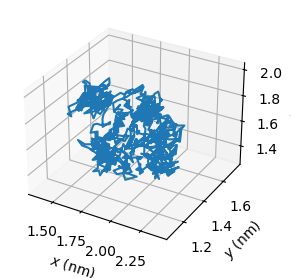

In [24]:
import matplotlib.pyplot as plt

com_pos = np.loadtxt("com.txt")

figure = plt.figure(figsize=(5, 4), layout="constrained")

axes = figure.add_subplot(1, 2, 1, projection="3d")
axes.plot(*com_pos.T)
axes.set_xlabel("$x$ (nm)")
axes.set_ylabel("$y$ (nm)")
axes.set_zlabel("$z$ (nm)")

plt.show()

## Summary

After following this tutorial, you should be able to:

* Set up an OpenMM simulation using Amber input files
* Retrieve and access the state of an OpenMM simulation as it runs
* Use OpenMM's builtin reporter classes to output simulation results, and write your own custom reporters

You may want to load input files from a molecular dynamics program other than Amber.  For CHARMM, you will need a PSF file with structure information, a CRD file with coordinates, and then force field files in CHARMM's RTF (residue topology), PRM (parameters), and/or STR (stream file) formats.  These files can be loaded into OpenMM like
```python
psf = CharmmPsfFile('input.psf')
crd = CharmmCrdFile('input.crd')
params = CharmmParameterSet('input.prm', 'input.rtf', 'input.str', ...) # Include as many files as needed
```
A Topology, positions, and a System can then be created like
```python
topology = psf.topology
positions = crd.positions
system = psf.createSystem(params, ...) # Include options here
```

For GROMACS, you will need a GRO file with coordinates, a TOP file with topology information, and a path to a directory with include files.  These can be loaded as
```python
gro = GromacsGroFile('input.gro')
top = GromacsTopFile('input.top', includeDir='/path/to/gromacs/share/gromacs/top',
    periodicBoxVectors=gro.getPeriodicBoxVectors())
```
and the Topology, positions, and System created as
```python
topology = top.topology
positions = gro.positions
system = top.createSystem(...) # Include options here
```

OpenMM can also load Tinker and Desmond files through similar interfaces (see below).

## Further Reading

* Relevant sections of the [User Guide](https://docs.openmm.org/latest/api-python/):
  * [Running Simulations](https://docs.openmm.org/latest/userguide/application/02_running_sims.html)
    * [Using AMBER Files](https://docs.openmm.org/latest/userguide/application/02_running_sims.html#using-amber-files)
    * [Using Gromacs Files](https://docs.openmm.org/latest/userguide/application/02_running_sims.html#using-gromacs-files)
    * [Using CHARMM Files](https://docs.openmm.org/latest/userguide/application/02_running_sims.html#using-charmm-files)
  * [Extracting and Reporting Forces (and other data)](https://docs.openmm.org/latest/userguide/application/04_advanced_sim_examples.html#extracting-and-reporting-forces-and-other-data)
* Information about other file formats:
  * [DesmondDMSFile](https://docs.openmm.org/latest/api-python/generated/openmm.app.desmonddmsfile.DesmondDMSFile.html) for loading Desmond files
  * [TinkerFiles](https://docs.openmm.org/latest/api-python/generated/openmm.app.tinkerfiles.TinkerFiles.html) for loading Tinker files (requires OpenMM 8.4 or later)
* [Python API documentation](https://docs.openmm.org/latest/api-python/) pages for new classes introduced in this tutorial:
  * [AmberInpcrdFile](https://docs.openmm.org/latest/api-python/generated/openmm.app.amberinpcrdfile.AmberInpcrdFile.html)
  * [AmberPrmtopFile](https://docs.openmm.org/latest/api-python/generated/openmm.app.amberprmtopfile.AmberPrmtopFile.html)
  * [CharmmCrdFile](https://docs.openmm.org/latest/api-python/generated/openmm.app.charmmcrdfiles.CharmmCrdFile.html)
  * [CharmmParameterSet](https://docs.openmm.org/latest/api-python/generated/openmm.app.charmmparameterset.CharmmParameterSet.html)
  * [CharmmPsfFile](https://docs.openmm.org/latest/api-python/generated/openmm.app.charmmpsffile.CharmmPsfFile.html)
  * [CheckpointReporter](https://docs.openmm.org/latest/api-python/generated/openmm.app.checkpointreporter.CheckpointReporter.html)
  * [DCDReporter](https://docs.openmm.org/latest/api-python/generated/openmm.app.dcdreporter.DCDReporter.html)
  * [GromacsGroFile](https://docs.openmm.org/latest/api-python/generated/openmm.app.gromacsgrofile.GromacsGroFile.html)
  * [GromacsTopFile](https://docs.openmm.org/latest/api-python/generated/openmm.app.gromacstopfile.GromacsTopFile.html)